In [1]:
include("src/polyatree.jl")
include("src/partitions.jl")

using Distributions
using Plots
using Serialization
using DataFrames
using LaTeXStrings
using Plots.PlotMeasures

# Example 1) Finite vs infinite Polya Tree

In [2]:
data1 = rand(Uniform(0, 0.5), 1000)
data2 = [rand(Uniform(0, 0.25), 1000); rand(Uniform(0.125, 0.25), 3000); rand(Uniform(0.5, 1.0), 2000)];
data3 = rand(truncated(Normal(0.5, 0.1), 0.0, 1.0), 1000);

datasets = [data1, data2, data3];

In [3]:
data = rand(Uniform(0, 0.5), 500000)
gfpt2 = GFPT1(Poisson(5.0), 10, 0.05, 0.05)
gfpt2 = update(data, gfpt2)

sum(collect(1:length(gfpt2.prob_n)) .* gfpt2.prob_n)

gfpt2.prob_n

MethodError: MethodError: no method matching GFPT1(::Poisson{Float64}, ::Int64, ::Float64, ::Float64)

Closest candidates are:
  GFPT1(::Distribution, ::Any, ::Any)
   @ Main ~/Documents/papers/polyatree/code/src/gfpt1.jl:19
  GFPT1(::Distribution, ::Any)
   @ Main ~/Documents/papers/polyatree/code/src/gfpt1.jl:19
  GFPT1(::Any, ::Any)
   @ Main ~/Documents/papers/polyatree/code/src/gfpt1.jl:5
  ...


In [4]:
function l1_dist(p_dens, q_dens, xgrid)
    return 0.5 * sum(abs.(p_dens .- q_dens)) * (xgrid[2] - xgrid[1])
end


function arclength(curve, xgrid, normalize=true)
    diffs = curve[2:end] .- curve[1:end-1]
    deltas = xgrid[2:end] .- xgrid[1:end-1]
    out = sum(
        (diffs.^2 .+ deltas.^2).^(1/2)
    )
    if normalize
        out -= sum(deltas)
    end
    return out
end

arclength (generic function with 2 methods)

In [6]:
xgrid = collect(LinRange(1e-7, 1.0 - 1e-7, 1000))
plots = []

for data in datasets
    gfpt1 = GFPT1(Poisson(5.0), 10, 2.0)
    simple_pt1 = deepcopy(gfpt1.pt)

    gfpt2 = GFPT1(Poisson(5.0), 10, 0.05)
    simple_pt2 = deepcopy(gfpt2.pt)

    simple_pt3 = PolyaTree(10, 10.0, 10.0)

    gfpt1 = update(data, gfpt1)
    simple_pt1 = update(data, simple_pt1)
    gfpt2 = update(data, gfpt2)
    simple_pt2 = update(data, simple_pt2)
    simple_pt3 = update(data, simple_pt3)

    ref_dens = pdf.(truncated(Normal(0.5, 0.1), 0.0, 1.0), xgrid)
    pred1 = predictive_density(xgrid, simple_pt2)
    pred2 = predictive_density(xgrid, gfpt2)
    p = plot()

    # plot!(xgrid, predictive_density(xgrid, gfpt1), color=1, label=L"\alpha_0: 2.0", linewidth=2.0)
    # plot!(xgrid, pred2, color=2,linewidth=2.0, label=L"\alpha_0: 0.05")

    plot!(xgrid, predictive_density(xgrid, simple_pt1), color=1, linestyle=:dot, label="", linewidth=1.5)
    plot!(xgrid, pred1, color=2,linewidth=1.5, alpha=0.5, linestyle=:dot, label="")


    tv1 = (0.5 * sum(abs.(pred1 .- ref_dens)) * (xgrid[2] - xgrid[1]))
    tv2 = (0.5 * sum(abs.(pred2 .- ref_dens)) * (xgrid[2] - xgrid[1]))
    println(tv1, "  ", tv2)
    plots = push!(plots, p)
end


plot((p for p in plots)..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=2)

#savefig("plots/example1.pdf")

MethodError: MethodError: Cannot `convert` an object of type Int64 to an object of type NestedPartitions

Closest candidates are:
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:64
  NestedPartitions(::Int64, !Matched::Array{SimplePartition}, !Matched::Array{Array{Float64}})
   @ Main ~/Documents/papers/polyatree/code/src/partitions.jl:25
  NestedPartitions(::Any, !Matched::Any, !Matched::Any)
   @ Main ~/Documents/papers/polyatree/code/src/partitions.jl:25


In [5]:
df = Serialization.deserialize("simulation1_results.dta");

In [6]:
PRIORS = [
    ("PT", 0.05),
    ("PT", 2.0),
    ("PT", 10.0),
    ("GFPT1", 0.05),
    ("GFPT1", 2.0),
    ("GFPT1", 10.0),
]

NDATAS = [50, 100, 1000, 5000, 10000];

In [7]:
mean_df = combine(groupby(df, [:Model, :alpha0, :DataGen, :Ndata]), 
                  :L1 => mean => :L1, :LENGTH => mean => :LENGTH,
                :POST_N => mean => :POST_N, :MODE_N => mean => :MODE_N);

median_df = combine(groupby(df, [:Model, :alpha0, :DataGen, :Ndata]), 
                :L1 => median => :L1, :LENGTH => median => :LENGTH,
                :POST_N => median => :POST_N, :MODE_N => median => :MODE_N);

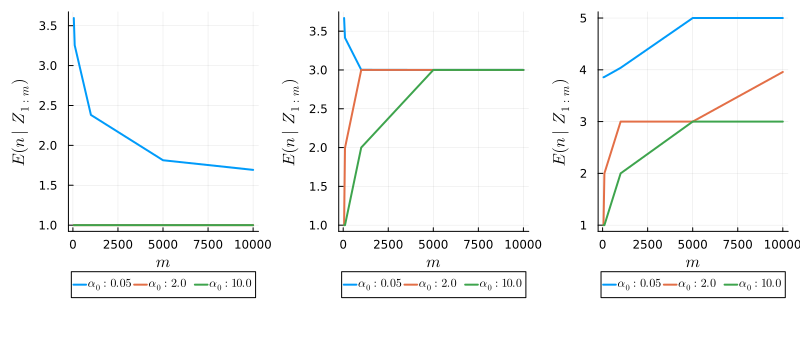

In [8]:
TO_PLOT = "POST_N"

if TO_PLOT == "L1"
    label=L"TV"
elseif TO_PLOT == "LENGTH"
    label=L"W"
elseif TO_PLOT == "POST_N"
    label=L"E(n\mid Z_{1:m})"
elseif TO_PLOT == "MODE_N"
    label=L"mode(n\mid Z_{1:m})"
end

plots = []
cols_by_a = Dict(0.05 => 1, 2.0 => 2, 10.0 => 3)

for dg in 1:3
    p = plot()
    curr_df = mean_df[mean_df.DataGen .== dg, :]
    for (i, prior) in enumerate(PRIORS)
        model, a0 = prior
        subdf = curr_df[(curr_df.Model .== prior[1]) .& (curr_df.alpha0 .== prior[2]), :]

        if model == "PT"
            if (TO_PLOT=="POST_N") || (TO_PLOT=="MODE_N")
                continue
            else
                plot!(NDATAS, subdf[!,TO_PLOT], linewidth=2.0, color=cols_by_a[a0], linestyle=:dash, label="")
            end
        else
            plot!(NDATAS, subdf[!, TO_PLOT], linewidth=2.0, color=cols_by_a[a0], 
                 label=L"\alpha_0: %$a0", 
                  xlabel=L"m", ylabel=label)
        end
    end
    plots = push!(plots, p)
end

plot((p for p in plots)..., layout=(1, 3), size=(800, 350), left_margin = 5mm, bottom_margin=5mm)
plot!(legend=:outerbottom, legendcolumns=3)#yscale=:log)

# savefig("../latex/images/simulation1_$TO_PLOT.pdf")


In [163]:
plots = []

cols_by_a = Dict(0.05 => 1, 2.0 => 2, 10.0 => 3)

for dg in 1:3
    p = plot()
    curr_df = df[df.DataGen .== dg, :]
    for (i, prior) in enumerate(PRIORS)
        model, alpha0 = prior
        subdf = curr_df[(curr_df.Model .== prior[1]) .& (curr_df.alpha0 .== prior[2]), :]

        if model == "PT"
            continue
        else
            plot!(NDATAS, subdf.POST_N, linewidth=2.0, color=cols_by_a[alpha0], label="$alpha0", 
                  xlabel=L"n", ylabel=L"p(n)")
        end
    end
    plots = push!(plots, p)
end

plot((p for p in plots)..., layout=(1, 3), size=(800, 250), left_margin = 5mm, bottom_margin=5mm)

# Example 2) GFPT2 vs GFPT1

In [19]:
DG1 = Uniform(0, 0.5)
DG2 = MixtureModel([
    Uniform(0, 0.25),
    Uniform(0.125, 0.25),
    Uniform(0.5, 1.0)], [1/6, 1/2, 1/3])
DG3 = truncated(Normal(0.5, 0.1), 0.0, 1.0)
DG4 = Uniform(0, 0.2)
DG5 = MixtureModel([
    Uniform(0, 0.2),
    Uniform(0.7, 0.9)], [2/3, 1/3])
DG6 = MixtureModel([
    Beta(2, 15),
    Beta(15, 2)], [1/2, 1/2])
DG = [DG1, DG2, DG3, DG4, DG5, DG6];

In [16]:
XGRID = collect(LinRange(1e-8, 1-1e-8, 1000))
MAX_DEPTH = 8

function get_posterior_summaries(pt::GFPT2, data)
    mcmc_chain = run_mcmc(data, pt, 10000, 5000, 5);
    pred_dens = predictive_density(XGRID, mcmc_chain)
    post_n_proba = zeros(MAX_DEPTH)
    for tree in mcmc_chain
        post_n_proba[tree.curr_n] += 1
    end
    post_n_proba ./= length(mcmc_chain)
    return post_n_proba, pred_dens
end


function get_posterior_summaries(pt::GFPT1, data)
    model = update(data, pt)
    pred_dens = predictive_density(XGRID, model)
    return model.prob_n, pred_dens
end


get_posterior_summaries (generic function with 2 methods)

In [17]:
preds_1 = []
preds_2 = []
post_n_1 = []
post_n_2 = []


for (i, datagen) in enumerate(DG)
    println("i: ", i)
    flush(stdout)
    data = rand(datagen, 500);
    pt = GFPT2(Poisson(3.0), 8, 0.1, 2.0);
    gfpt1 = GFPT1(Poisson(3.0), 8, 0.1);

    post_n, pred = get_posterior_summaries(pt, data)
    preds_2 = push!(preds_2, pred)
    post_n_2 = push!(post_n_2, post_n)

    post_n, pred = get_posterior_summaries(gfpt1, data)
    preds_1 = push!(preds_1, pred)
    post_n_1 = push!(post_n_1, post_n)
end

i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7


In [68]:
plots = []
for (i, datagen) in enumerate(DG)
    p = plot()
    true_dens = pdf.(datagen, XGRID)
    plot!(XGRID, true_dens, color="black", label="True", linewidth=2.0, title="DG"*string(i))
    plot!(XGRID, preds_1[i], color=1, label="GFPT1", linewidth=2.0)
    plot!(XGRID, preds_2[i], color=2, label="GFPT2", linewidth=2.0)
    plots = push!(plots, p)
end
    

In [69]:
plot((p for p in plots[1:3])..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=3)
savefig(savefig("../latex/images/gfpt_12_ex1_dens.pdf"))


"/Users/marioberaha/Documents/papers/polyatree/latex/images/gfpt_12_ex1_dens.pdf"

In [70]:
plot((p for p in plots[4:end])..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=3)
savefig(savefig("../latex/images/gfpt_12_ex2_dens.pdf"))


"/Users/marioberaha/Documents/papers/polyatree/latex/images/gfpt_12_ex2_dens.pdf"

In [60]:
using StatsPlots

plots = []
for (i, datagen) in enumerate(DG)
    p = plot()
    bars = [post_n_1[i]; post_n_2[i]]
    labels = repeat(["GFPT1", "GFPT2"], inner = 8)
    groupedbar!(repeat(collect(1:8), outer=2), bars, group=labels, xticks=collect(1:8), 
                title="DG"*string(i), ylabel=L"P(N=n \,|\, Z)", xlabel=L"n", ylim=(0.0, 1.0))
    plots = push!(plots, p)
end

In [66]:
plot((p for p in plots[1:3])..., layout=(1, 3), size=(810, 350))
plot!(legend=:outerbottom, legendcolumns=2, left_margin = 5mm, bottom_margin=5mm)
savefig(savefig("../latex/images/gfpt_12_ex1_post_n.pdf"))

"/Users/marioberaha/Documents/papers/polyatree/latex/images/gfpt_12_ex1_post_n.pdf"

In [67]:
plot((p for p in plots[4:end])..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=2, left_margin = 5mm, bottom_margin=5mm)
savefig(savefig("../latex/images/gfpt_12_ex2_post_n.pdf"))


"/Users/marioberaha/Documents/papers/polyatree/latex/images/gfpt_12_ex2_post_n.pdf"

# Quantitative metrics

In [2]:
NREP = 90

tmp = []

for iternum in 1:NREP
    curr_df = Serialization.deserialize("out/simulation2_"*string(iternum)*".dta")
    tmp = push!(tmp, curr_df)
end

df = reduce(vcat, tmp);

mean_df = combine(groupby(df, [:Model, :alpha0, :beta0, :increasing_beta, :DataGen, :Ndata]), 
                  :L1 => mean => :L1, :LENGTH => mean => :LENGTH,
                  :POST_N => mean => :POST_N);

In [3]:
PRIORS = [
    # ("GFPT1", 0.05, -1, false),
    ("GFPT1", 0.1, -1, false),
    # ("GFPT2", 0.1, 0.5, true),
    ("GFPT2", 0.1, 1.0, true),
    ("GFPT2", 0.1, 2.0, true),
    # ("GFPT2", 0.1, 5.0, true),
    # ("GFPT2", 0.1, 0.5, false),
    ("GFPT2", 0.1, 1.0, false),
    ("GFPT2", 0.1, 2.0, false),
    # ("GFPT2", 0.1, 5.0, false)
]

NDATAS = [50, 100, 250, 500];

In [24]:
TO_PLOT = "LENGTH"

yscale=:log
if TO_PLOT == "L1"
    label=L"TV"
elseif TO_PLOT == "LENGTH"
    label=L"W"
elseif TO_PLOT == "POST_N"
    label=L"E(N \mid Z_{1:m})"
    yscale=:identity
end

plots = []
cols_by_beta = Dict(-1 => 1, 1.0 => 2, 2.0 => 3)

l = @layout [grid(2, 3) 
             a{0.02h}]
# l = @layout [grid(2, 3)]

for dg in 1:6
    println("DG: ", dg)
    curr_df = mean_df[mean_df.DataGen .== dg, :]
    p = plot()
    for i in 1:length(PRIORS)
        prior = PRIORS[i]
        model, a0, b0, increasing_beta = prior
        subdf = filter([:Model, :alpha0, :beta0, :increasing_beta] => (x, y, z, w) ->
                        (x, y, z, w) == prior, curr_df)
        
        if model == "GFPT1"
            ls = :dash
            leg = L"GFPT1, \alpha_0: %$a0"
        else
            ls = increasing_beta ? :dot : :solid
            leg = increasing_beta ? "" : L"\alpha_0: %$a0, \beta_0: %$b0"

        end

        plot!(NDATAS, subdf[!, TO_PLOT], linewidth=2.0, linestyle=ls, color=cols_by_beta[b0], 
                    label=leg, xlabel=L"m", ylabel=label, legend=:none, title="DG$dg")
    end
    # if dg == 5
    #     plot!(legend=:outerbottom, legendcolumns=3)
    # end
    plots = push!(plots, p)
end

# Fake plot just for the legend 

dg = 1
curr_df = mean_df[mean_df.DataGen .== dg, :]
p = plot()
for i in 1:length(PRIORS)
    prior = PRIORS[i]
    model, a0, b0, increasing_beta = prior
    
    if model == "GFPT1"
        ls = :dash
        leg = L"GFPT1, \alpha_0: %$a0"
    else
        ls = increasing_beta ? :dot : :solid
        leg = increasing_beta ? "" : L"\alpha_0: %$a0, \beta_0: %$b0"

    end

    plot!(1:10, 1:10, linewidth=2.0, linestyle=ls, color=cols_by_beta[b0], 
            label=leg, grid=false, xlims=(20,3), showaxis=false, legend=:inside, legendcolumns=3)
end
plots = push!(plots, p)


plot((p for p in plots)..., layout=l, size=(800, 600), left_margin = 5mm, bottom_margin=5mm, yscale=yscale)
savefig("../latex/images/simulation2_$TO_PLOT.pdf")

DG: 1
DG: 2
DG: 3
DG: 4
DG: 5
DG: 6


"/Users/marioberaha/Documents/papers/polyatree/latex/images/simulation2_LENGTH.pdf"